# 環保署測站資料整理

## 1. Introduction

這個 jupyter notebook 提供了工具和範例，把環保署測站的歷史資料集合在一起。

### 資料

下載 1991~2017 年環保署所有測站資料，解壓縮放在 `./source_taqm.epa/download/` 中，以西元年份作為資料夾名稱。


### 資料特性

依年份不同，環保署測站年度資料主要有兩種格式：csv 與 xls+ods。


## 2. Utility Functions

工具函數

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re, os

def detect_epa_nan(x):
    ''' Search for missing value symbol and assign np.nan '''
    if re.findall('\#|\*|x', str(x))!=[]:
        return(np.nan)
    else:
        return(x)

def detect_epa_norain(x):
    ''' Replace 'NR' (no-rain) with 0 '''
    if str(x)=='NR':
        return(0)
    else:
        return(x)

def clean_epa_station(x):
    ''' Clean up a EPA station dataset '''
    # Rename columns
    col_names = ['date','station','item','h00','h01','h02','h03','h04','h05','h06','h07','h08','h09',
                'h10','h11','h12','h13','h14','h15','h16','h17','h18','h19','h20','h21','h22','h23']
    x.columns = col_names
    # Process NA and NR
    floatdata = x.iloc[:,3:]
    floatdata = floatdata.applymap(detect_epa_nan)
    floatdata = floatdata.applymap(detect_epa_norain)
    floatdata.astype(np.float32)
    x.iloc[:,3:] = floatdata
    # Done
    return(x)

# Retrieve one item from EPA data and form a time series
def retrieve_epa_item(data, var):
    tmp = data.loc[data['item']==var,:]
    ts = pd.melt(tmp, id_vars=['date'], value_vars=tmp.keys()[3:], var_name='hour', value_name=var)
    ts[var] = ts[var].astype(np.float32)
    return(ts)


## 3. 尋找目錄下的所有檔案

由於環保署資料包含了很多個檔案，又依照空品區的劃分，放在不同的資料夾底下，因此我們需要借助 python 的 [`os.walk()`](https://docs.python.org/3/library/os.html) 函數，幫我們自動「走遍」資料夾底下的每個檔案。

此外，由於資料的檔名包含了測站名稱，我們可以順便把測站名稱取出來，作為欄位的名稱，所以我們需要用到 [`str.find()`](https://www.tutorialspoint.com/python/string_find.htm) 函數，來幫我們找到測站名稱在檔名裡的位置。

In [2]:
# Walk through the specified path and find all files ended with 'xls'
def find_epa_files(path, verbose=0):
    ids = []    # 測站名稱
    urls = []   # 檔案完整路徑
    for root, dirs, files in os.walk(path):             # os.walk() 會傳回「根目錄」、「路徑」、和「檔名」三個字串 list
        for fname in files:                             # 每個檔名
            if(fname.endswith('.xls') or fname.endswith('.csv')):  # 如果是以 xls or csv 結尾
                if verbose>0:
                    print(os.path.join(root, fname))
                fid = fname[(fname.find('年')+1):]
                fid = fid[:(fid.find('_')-1)]
                ids.append(fid)
                urls.append(os.path.join(root, fname))
    return((ids,urls))


由於環保署資料的檔名是以 *YYY年XX站_YYYYMMDD.xls* 的格式命名 ，例如：104年花蓮站_20160320.xls，我們要取出字串裡的 *XX*，所以我們要：

1. 從完整檔名裡找到 *'104年'* 之後的字串 A
2. 從 A 裡找到 *'_2016'* 前面的字串，不包含「站」

因此，我們的寫法會是：

In [3]:
fn = '100年三義站_20120409.csv'
fn1 = fn[(fn.find('年')+1):]
print(fn1)
fn2 = fn1[:(fn1.find('_')-1)]
print(fn2)

三義站_20120409.csv
三義


In [4]:
ids, epafiles = find_epa_files('source_taqm.epa'+os.path.sep+'download'+os.path.sep+'2011'+os.path.sep)
print(ids)

['二林', '南投', '埔里', '大里', '崇倫', '彰化', '忠明', '沙鹿', '竹山', '線西', '西屯', '豐原', '阿里山', '三重', '中壢', '中山', '古亭', '土城', '基隆', '士林', '大同', '大園', '平鎮', '新店', '新莊', '松山', '板橋', '林口', '桃園', '永和', '汐止', '淡水', '菜寮', '萬華', '萬里', '觀音', '陽明', '龍潭', '冬山', '宜蘭', '三義', '新竹', '湖口', '竹東', '苗栗', '頭份', '台東', '花蓮', '關山', '金門', '馬公', '馬祖', '台南', '台西', '善化', '嘉義', '安南', '崙背', '斗六', '新港', '新營', '朴子', '麥寮', '仁武', '前金', '前鎮', '大寮', '小港', '屏東', '左營', '復興', '恆春', '林園', '楠梓', '橋頭', '潮州', '美濃', '鳳山']


## 4. 探索檔案內容

由於每年的測站、測項、缺失值的情況都不盡相同，我們在分析之前，可以初步探索一下 EPA 資料的整體狀況。我們需要一個函數，讀進一個測站觀測檔，然後計算這個資料檔裡的測站、年份，和各個觀測項目的完整性。

In [5]:
def summarize_epa_file(furi):
    # Check file extension and read in
    if furi.endswith('.xls'):
        data = pd.read_excel(furi)
    elif furi.endswith('.csv'):
        data = pd.read_csv(open(furi, 'r', encoding='big5'))
    else:
        print('File '+furi+' not recognizable, skipped.')
        return(None)
    # Clean up data
    data = clean_epa_station(data)
    # List all items
    items = list(set(data['item']))
    # Convert to a time*item table
    newdata = retrieve_epa_item(data, items[0])
    for i in items[1:]:
        tmp = retrieve_epa_item(data, i)
        newdata = newdata.merge(tmp, on=['date','hour'], how='left')
    # Sort with date-hour to make the time-series in order
    newdata = newdata.sort_values(['date', 'hour'])
    # Create summary
    nacounts = newdata.apply(lambda x: (len(x)-x.count())/len(x))
    fyear = str(data['date'][0])[:4]
    station = data['station'][0]
    summ = pd.Series([station, fyear]+list(nacounts[2:]), index=['station','year']+list(nacounts.index[2:]))
    # 
    return(summ)

In [6]:
def summarize_epa_files(epafiles):
    # Collect data from all files
    f = epafiles[0]                             # Start from the first file
    data = summarize_epa_file(f).to_frame()     # Brief summary
    for f in epafiles[1:]:
        tmp = summarize_epa_file(f)
        if tmp is not None:
            data = pd.merge(data, tmp.to_frame(), left_index=True, right_index=True, how='outer')
    return(data.T)

## 5. 實際進行資料的讀取、清理與合併

接下來，我們就用上面的函數，讀進各個測站、各年份的資料，進行整理。

In [7]:
print(epafiles[0])
#import csv
#with open(epafiles[0], 'r', encoding='big5') as cf:
#    cr = csv.reader(cf)
#    for r in cr:
#        print(r)
#d = pd.read_csv(open(epafiles[0], 'r',encoding='big5'))
d = summarize_epa_files(epafiles)
d.shape

source_taqm.epa\download\2011\100_HOUR_00_20120409\100年 中部空品區\100年二林站_20120409.csv


(78, 23)

## 視覺化資料完整性

合併後的資料量比較大，我們也可以透過簡單的視覺化來檢視：

(78, 23)


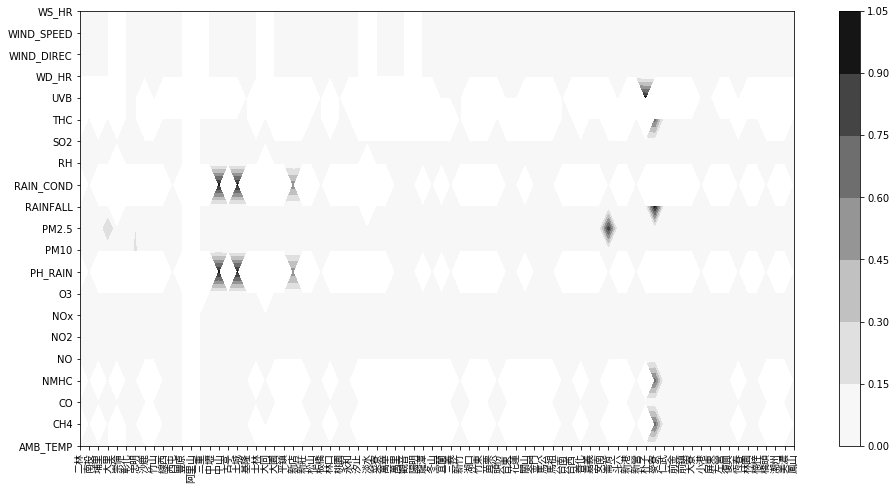

In [8]:
print(d.shape)

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="NotoSansCJKtc-Regular.otf", size=10)

dp = d.drop(columns=['station', 'year'])
plt.figure(figsize=(16,8))
plt.contourf(dp.T, cmap='Greys')
plt.xticks(np.arange(dp.shape[0]), d['station'], rotation=90, fontproperties=font)
plt.yticks(np.arange((dp.shape[1])), dp.keys())
plt.colorbar()
plt.show()

可以從圖上看到各個觀測項目在個測站遺失值比例的分佈，可以考慮將遺失值過多的測項或是測站排除在整體資料集之外。

我們可以把上述的工具，使用在 2000 ~ 2014 年的資料上，來決定資料集的範圍。

In [9]:
# Define the search range
years = np.arange(2000, 2015, 1)
srcdir = './source_taqm.epa/download/'
dirs = [srcdir+str(y)+'/' for y in years]
#
summ_by_year = {}
id_by_year = {}
for y in years:
    print(y)
    ids, epafiles = find_epa_files(srcdir+str(y)+'/')
    #print(epafiles)
    id_by_year[str(y)] = ids
    summ_by_year[str(y)] = summarize_epa_files(epafiles)
    print(summ_by_year[str(y)].shape)
#


2000
(74, 21)
2001
(73, 21)
2002
(75, 21)
2003
(76, 21)
2004
(76, 21)
2005
(78, 21)
2006
(77, 21)
2007
(77, 23)
2008
(77, 43)
2009
(77, 23)
2010
(77, 23)
2011
(78, 23)
2012
(76, 23)
2013
(76, 23)
2014
(76, 23)


In [10]:
# Save results with pickle
import pickle
with open('summ_by_year.pkl','wb') as jf:
    pickle.dump(summ_by_year, jf)
with open('id_by_year.pkl','wb') as jf2:
    pickle.dump(id_by_year, jf2)

## *分段點*

由於上一步的處理程序比較耗時，我們在此設置一個分段點，把之前處理的結果存到磁碟上，後續分析可以從這裡繼續，不必重複執行以上的步驟。

In [11]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re, os
import pickle

with open('summ_by_year.pkl','rb') as jf:
    summ_by_year = pickle.load(jf)
with open('id_by_year.pkl','rb') as jf2:
    id_by_year = pickle.load(jf2)

(15, 82)


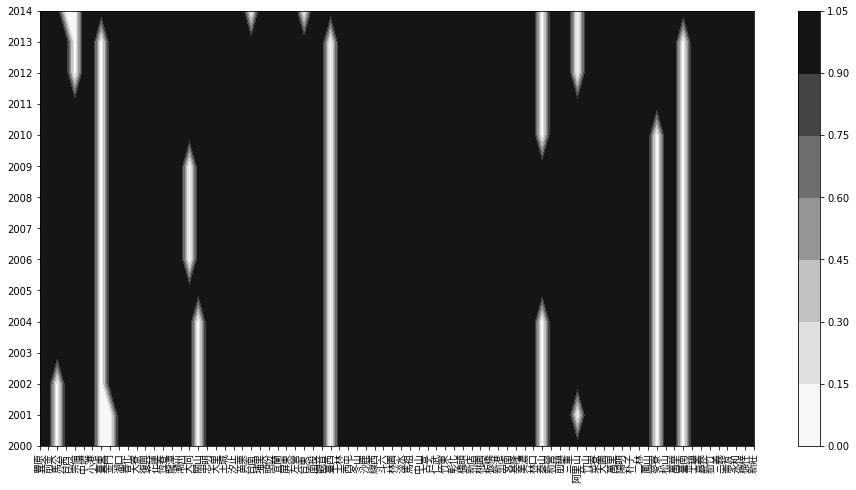

(15, 68)


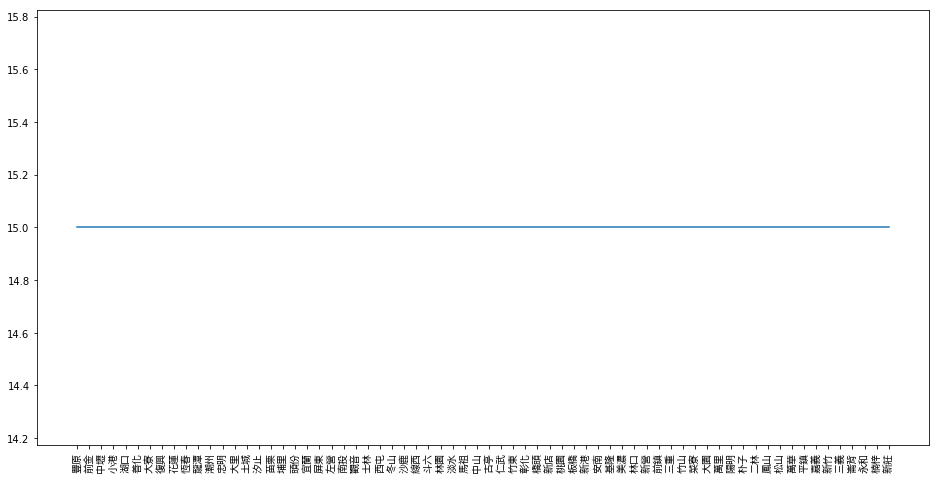

Index(['豐原', '前金', '中壢', '小港', '湖口', '善化', '大寮', '復興', '花蓮', '恆春', '龍潭', '潮州',
       '忠明', '大里', '土城', '汐止', '苗栗', '埔里', '頭份', '宜蘭', '屏東', '左營', '南投', '觀音',
       '士林', '西屯', '冬山', '沙鹿', '線西', '斗六', '林園', '淡水', '馬祖', '中山', '古亭', '仁武',
       '竹東', '彰化', '橋頭', '新店', '桃園', '板橋', '新港', '安南', '基隆', '美濃', '林口', '新營',
       '前鎮', '三重', '竹山', '菜寮', '大園', '萬里', '陽明', '朴子', '二林', '鳳山', '松山', '萬華',
       '平鎮', '嘉義', '新竹', '三義', '崙背', '永和', '楠梓', '新莊'],
      dtype='object')

In [12]:
# -*- coding: utf-8 -*-
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="NotoSansCJKtc-Regular.otf", size=10)
#plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
#plt.rcParams['axes.unicode_minus'] = False
# check the station availability with (id_by_year)
all_sta = set(sum(id_by_year.values(),[]))
df = pd.DataFrame(np.zeros((len(id_by_year), len(all_sta)), dtype=np.int8), index=id_by_year.keys(), columns=all_sta)
for y in id_by_year:
    #print(y)
    for s in id_by_year[y]:
        #print(s)
        df.loc[y,s] = 1
#
print(df.shape)
plt.figure(figsize=(16,8))
plt.contourf(df, cmap='Greys')
plt.xticks(np.arange(df.shape[1]), all_sta, rotation=90, fontproperties=font)
plt.yticks(np.arange((df.shape[0])), id_by_year.keys())
plt.colorbar()
plt.show()
# Keep only complete stations
df2 = df.loc[:,df.sum(axis=0)==15]
print(df2.shape)
plt.figure(figsize=(16,8))
plt.plot(df2.sum(axis=0))
plt.xticks(np.arange(df2.shape[1]), df2.keys(), rotation=90, fontproperties=font)
plt.show()
stn15yr = df2.keys()
stn15yr

我們可以看到，15年（2000 ~ 2014）每年有資料的測站不盡相同，為了分析上的方便，我們只保留15年都有資料的68個測站。接下來，我們也用類似的標準來篩選觀測項目，由於分析的主要標的是 PM2.5，因此缺少這個觀測項目的測站會進一步被刪除（missing value < M%），另外，我們也希望只保留大部分觀測站都有的觀測項目，以利後續分析。

In [13]:
# Collect all existing items in the raw data
all_items = []
for y in summ_by_year.keys():
    all_items+=list(summ_by_year[y].keys())
all_items = list(set(all_items))

# Make two tables: item-by-station and item-by-year
ibs = pd.DataFrame(np.empty((len(all_sta), len(all_items))).fill(np.nan), index=all_sta, columns=all_items)
iby = pd.DataFrame(np.empty((len(summ_by_year), len(all_items))).fill(np.nan), index=list(summ_by_year.keys()), columns=all_items)
print(ibs.shape)
print(iby.shape)
# Fill in tables
for y in summ_by_year.keys():
    print('Year: '+y)
    # Calculate annual mean of items
    item_year_mean = summ_by_year[y].mean(axis=0)
    for i in item_year_mean.keys():
        if iby.loc[y,i] is np.nan:
            iby.loc[y,i] = item_year_mean[i]
        else:
            iby.loc[y,i] += item_year_mean[i]
    # Calculate station-item
    stns = summ_by_year[y]['station']
    summ = summ_by_year[y].drop(['station', 'year'], axis=1)
    for sidx in np.arange(summ.shape[0]):
        for i in summ.keys():
            #print(str(sidx) + ' ' + stns.iloc[sidx] + ':' + i)
            if ibs.loc[stns.iloc[sidx],i] is np.nan:
                ibs.loc[stns.iloc[sidx],i] = summ[i].iloc[sidx]
            else:
                ibs.loc[stns.iloc[sidx],i] += summ[i].iloc[sidx]


(82, 43)
(15, 43)
Year: 2000
Year: 2001
Year: 2002
Year: 2003
Year: 2004
Year: 2005
Year: 2006
Year: 2007
Year: 2008
Year: 2009
Year: 2010
Year: 2011
Year: 2012
Year: 2013
Year: 2014


## 資料的輸出

Python 的輸出/輸入非常多樣，我們這裡介紹 pandas.DataFrame 內建的輸出/輸入工具。在我們讀取資料的時候，使用了 [pandas.read_csv()](https://pandas.pydata.org/pandas-docs/stable/io.html#io-read-csv-table) 與 [pandas.read_excel()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_excel.html)，想當然耳，pandas 也提供了輸出成這兩種格式的工具 [pandas.DataFrame.to_csv()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html) / [pandas.DataFrame.to_excel()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_excel.html)。

對於「表格式」的資料來說，CSV 大概是最常用的資料格式，下面我們就把整理好的資料輸出成 csv 檔，方便後續的分析來使用。

In [14]:
ibs.to_csv('../ibs.csv')
iby.to_csv('../iby.csv')

## Items by Year

Let's see the missing value proportion of observation items by year, and by stations.

(15, 43)
(15, 19)


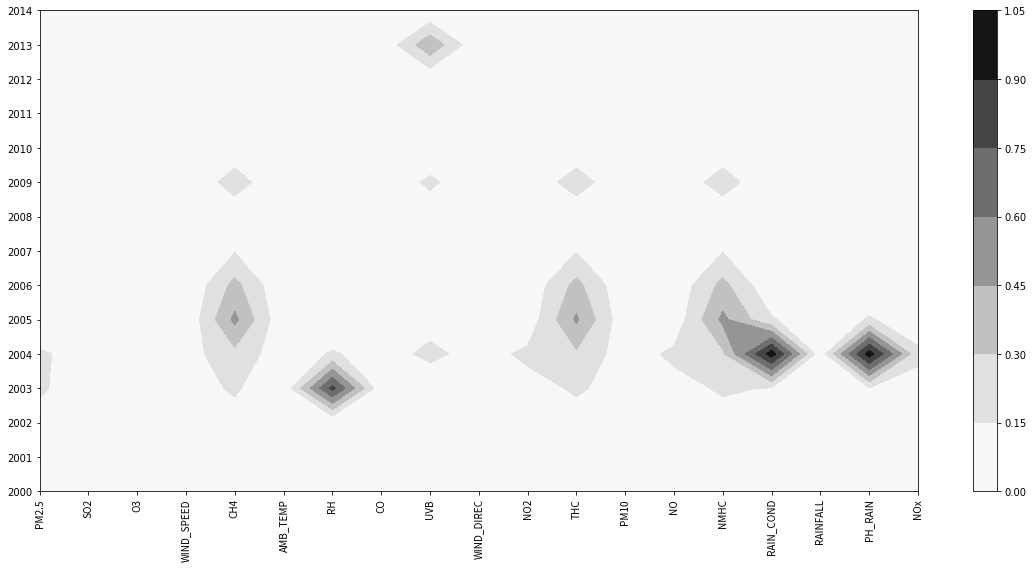

['PM2.5', 'SO2', 'O3', 'WIND_SPEED', 'CH4', 'AMB_TEMP', 'RH', 'CO', 'UVB', 'WIND_DIREC', 'NO2', 'THC', 'PM10', 'NO', 'NMHC', 'RAIN_COND', 'RAINFALL', 'PH_RAIN', 'NOx']


In [15]:
# For Chinese font
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="NotoSansCJKtc-Regular.otf", size=10)
# Keep only items existing through 15 years
df = iby.dropna(axis=1)
df = df.drop(columns=['year'])
print(iby.shape)
print(df.shape)
# Plot
plt.figure(figsize=(16,8))
plt.contourf(df, cmap='Greys')
plt.xticks(np.arange(df.shape[1]), df.keys(), rotation=90, fontproperties=font)
plt.yticks(np.arange((df.shape[0])), df.index)
plt.colorbar()
plt.tight_layout()
plt.show()
#
item15yr = list(df.keys())
print(item15yr)

上圖顯示的是15年都有資料的19個觀測項目，每年68個測站的平均 missing value ratio，可以看到 2004 年前後有比較多的資料缺失，而一實質比較多的觀測項目有 PH_RAIN, RAIN_COND, UVB, CH4, NMHC, THC，可以考慮排除，只使用剩餘的13個觀測項目。

圖中 PM2.5 在2004年前後其實也有比較多的資料缺失，但是作為主要分析的標的，可能「移除缺失嚴重的測站」會是比較好的選擇。

(82, 43)
(68, 19)


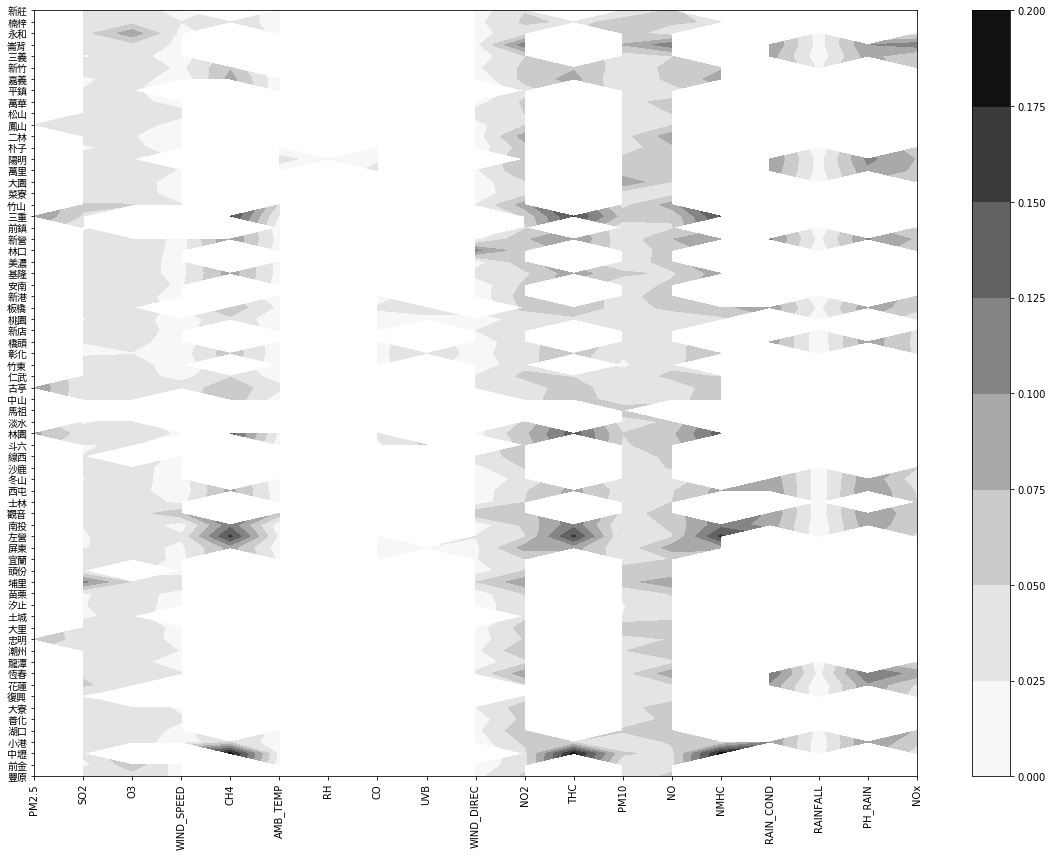

忠明    0.0658668
林園    0.0817087
古亭    0.0967787
三重    0.0975997
鳳山    0.0481014
Name: PM2.5, dtype: object

In [16]:
# Keep only items and stations existing through 15 years
df = ibs
df = df.loc[stn15yr,item15yr]/15
print(ibs.shape)
print(df.shape)
# Plot
plt.figure(figsize=(16,12))
plt.contourf(df, cmap='Greys')
plt.xticks(np.arange(df.shape[1]), df.keys(), rotation=90)
plt.yticks(np.arange((df.shape[0])), df.index, fontproperties=font)
plt.colorbar()
plt.tight_layout()
plt.show()
#
df['PM2.5'].dropna()

上圖是68個測站在19個觀測項目裡，15年的平均 missing value ratio。我們可以看到某些測站有比較多的觀測項目有缺失資料，而單以 PM2.5 來看，如果我們不希望有任何 missing values，可以再排除5個測站。

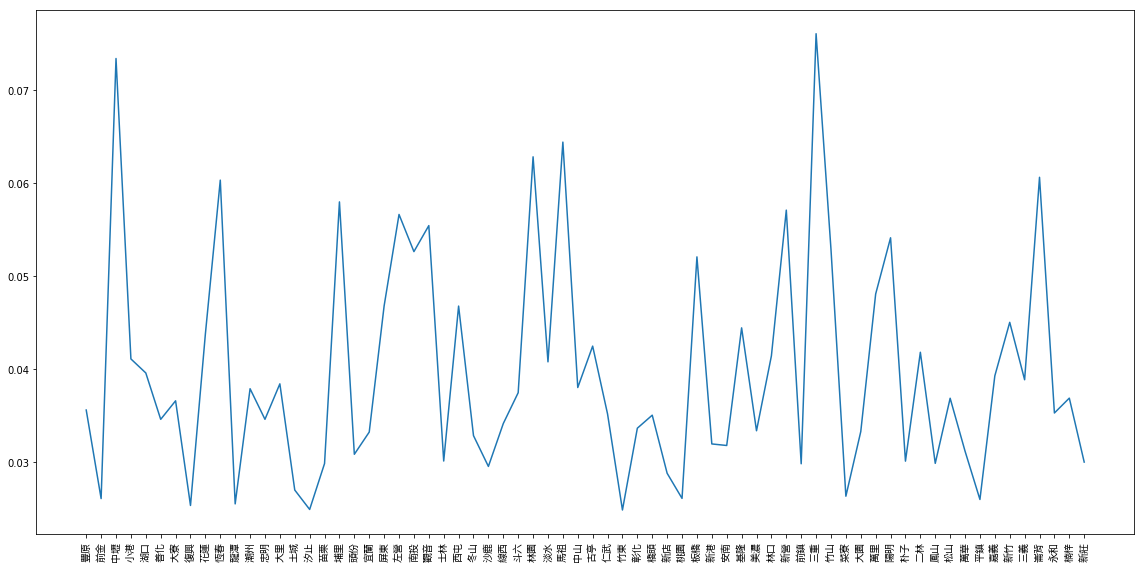

中壢    0.073364
恆春    0.060285
埔里    0.057945
左營    0.056595
南投    0.052600
觀音    0.055396
林園    0.062792
馬祖    0.064374
板橋    0.052033
新營    0.057060
三重    0.076030
竹山    0.052842
陽明    0.054087
崙背    0.060591
dtype: float64

In [17]:
# Plot station average
plt.figure(figsize=(16,8))
plt.plot(df.mean(axis=1))
plt.xticks(np.arange((df.shape[0])), df.index, fontproperties=font, rotation=90)
plt.tight_layout()
plt.show()
#
tmp = df.mean(axis=1)
tmp.loc[tmp>0.05]

如果以19個觀測項目的平均遺失率小於5％來考慮，則可以排除 13 個測站。

## 資料集

最後的資料集，以 13 個觀測項目和 63 個測站為主，格式為：每個觀測項目為一個檔案，每個檔案為 63 個測站15年逐時的觀測結果。

In [18]:
item_to_remove = ['PH_RAIN', 'RAIN_COND', 'UVB', 'CH4', 'NMHC', 'THC']
stn_to_remove = ['古亭', '忠明', '鳳山' ,'三重' ,'林園']

item_final = [i for i in item15yr if i not in item_to_remove]
stn_final = [s for s in stn15yr if s not in stn_to_remove]

# Print data sizes
print((len(item15yr),len(stn15yr)))
print((len(item_final),len(stn_final)))

print(item_final)
print(stn_final)

(19, 68)
(13, 63)
['PM2.5', 'SO2', 'O3', 'WIND_SPEED', 'AMB_TEMP', 'RH', 'CO', 'WIND_DIREC', 'NO2', 'PM10', 'NO', 'RAINFALL', 'NOx']
['豐原', '前金', '中壢', '小港', '湖口', '善化', '大寮', '復興', '花蓮', '恆春', '龍潭', '潮州', '大里', '土城', '汐止', '苗栗', '埔里', '頭份', '宜蘭', '屏東', '左營', '南投', '觀音', '士林', '西屯', '冬山', '沙鹿', '線西', '斗六', '淡水', '馬祖', '中山', '仁武', '竹東', '彰化', '橋頭', '新店', '桃園', '板橋', '新港', '安南', '基隆', '美濃', '林口', '新營', '前鎮', '竹山', '菜寮', '大園', '萬里', '陽明', '朴子', '二林', '松山', '萬華', '平鎮', '嘉義', '新竹', '三義', '崙背', '永和', '楠梓', '新莊']


## 產生資料集

最後，我們依據選取的測站跟觀測項目，來產生分析用的資料集。

In [19]:
# Read in a single EPA file
def read_epa_file(furi, itemlist):
    # Check file extension and read in
    if furi.endswith('.xls'):
        data = pd.read_excel(furi)
    elif furi.endswith('.csv'):
        data = pd.read_csv(open(furi, 'r', encoding='big5'))
    else:
        print('File '+furi+' not recognizable, skipped.')
        return(None)
    # Clean up data
    data = clean_epa_station(data)
    # List all items
    #items = list(set(data['item']))
    items = itemlist
    # Create time stamps
    dates = pd.Series(sorted(list(set(data['date']))))
    hours = data.keys()[3:]
    thead = []
    for d in dates:
        for h in hours:
            thead.append({'date':d, 'hour':h})
    thead = pd.DataFrame(thead)
    # Convert to a time*item table
    newdata = thead
    #newdata = retrieve_epa_item(data, items[0])
    for i in items:
        tmp = retrieve_epa_item(data, i)
        newdata = newdata.merge(tmp, on=['date','hour'], how='left')
    # Sort with date-hour to make the time-series in order
    newdata = newdata.sort_values(['date', 'hour'])
    newdata = newdata.reset_index(drop=True)
    # 
    return(newdata)

# Read in all EPA files of the specified year
def read_epa_year(srcdir, year, stnlist, itemlist):
    # Data preparation
    ids, epafiles = find_epa_files(srcdir+str(year)+'/')        # Search for files to read
    finfo = pd.DataFrame({'id':ids, 'furi':epafiles})           # Create data frame for processing
    print(finfo.shape)
    todrop = [ids.index(i) for i in ids if i not in stnlist]  # Drop unnecessary stations
    finfo = finfo.drop(index=todrop)
    print(finfo.shape)
    # Read the files
    newdata = []
    for f in np.arange(finfo.shape[0]):
        data = read_epa_file(finfo['furi'].iloc[f], itemlist) # Read file
        data['station'] = finfo['id'].iloc[f]                   # Add station id
        newdata.append(data)
    # Concat to data frame
    newdata = pd.concat(newdata,ignore_index=True).sort_values(['date', 'hour','station'])
    return(newdata)

In [20]:
# Define parameters
stn_final = ['嘉義', '龍潭', '淡水', '湖口', '苗栗', '美濃', '大園', '前鎮', '基隆', '板橋', '古亭', '南投',
       '潮州', '小港', '仁武', '花蓮', '馬祖', '崙背', '萬華', '冬山', '竹東', '松山', '沙鹿', '忠明',
       '大寮', '頭份', '屏東', '中壢', '恆春', '新竹', '士林', '觀音', '線西', '左營', '埔里', '新店',
       '新莊', '永和', '菜寮', '朴子', '彰化', '汐止', '復興', '前金', '平鎮', '西屯', '林口', '桃園',
       '豐原', '三義', '宜蘭', '鳳山', '大里', '二林', '楠梓', '竹山', '橋頭', '土城', '陽明', '善化',
       '萬里', '三重', '新營', '斗六', '中山', '新港', '安南', '林園']
# Define the search range
years = np.arange(2000, 2015, 1)
srcdir = './source_taqm.epa/download/'
# Read all files
output = []
for y in years:
    print(y)
    tmp = read_epa_year(srcdir, y, stn_final, item_final)
    output.append(tmp)
output = pd.concat(output, sort=False)
output.shape

2000
(74, 2)
(68, 2)
2001
(73, 2)
(68, 2)
2002
(75, 2)
(68, 2)
2003
(76, 2)
(68, 2)
2004
(76, 2)
(68, 2)
2005
(78, 2)
(68, 2)
2006
(77, 2)
(68, 2)
2007
(77, 2)
(68, 2)
2008
(77, 2)
(68, 2)
2009
(77, 2)
(68, 2)
2010
(77, 2)
(68, 2)
2011
(78, 2)
(68, 2)
2012
(76, 2)
(68, 2)
2013
(76, 2)
(68, 2)
2014
(76, 2)
(68, 2)


(8899632, 16)

In [21]:
output.to_pickle('epa_2000_2014.pkl')

## *分段點*
以下是對整理好的資料作進一步處理

In [22]:
import pickle, os, re
import numpy as np
import pandas as pd
output = pd.read_pickle('epa_2000_2014.pkl').sort_values(['station','date', 'hour'])
output.head()

,date,hour,PM2.5,SO2,O3,WIND_SPEED,AMB_TEMP,RH,CO,WIND_DIREC,NO2,PM10,NO,RAINFALL,NOx,station
324624,2008-01-01 00:00:00,h00,19.0,6.6,25.500000,6.66,8.21,65.070000,0.29,50.970001,10.62,51.0,0.35,0.0,10.97,三義
324625,2008-01-01 00:00:00,h01,19.0,6.7,26.299999,6.43,8.49,64.080002,0.27,40.480000,8.89,53.0,0.41,0.0,9.30,三義
324626,2008-01-01 00:00:00,h02,19.0,6.4,27.299999,7.21,8.59,60.369999,0.26,46.060001,8.19,49.0,0.39,0.0,8.58,三義
324627,2008-01-01 00:00:00,h03,18.0,6.1,28.600000,7.58,8.53,61.529999,0.26,41.810001,6.83,46.0,0.35,0.0,7.18,三義
324628,2008-01-01 00:00:00,h04,20.0,6.2,29.200001,7.80,8.44,60.570000,0.26,38.500000,6.57,47.0,0.45,0.0,7.02,三義


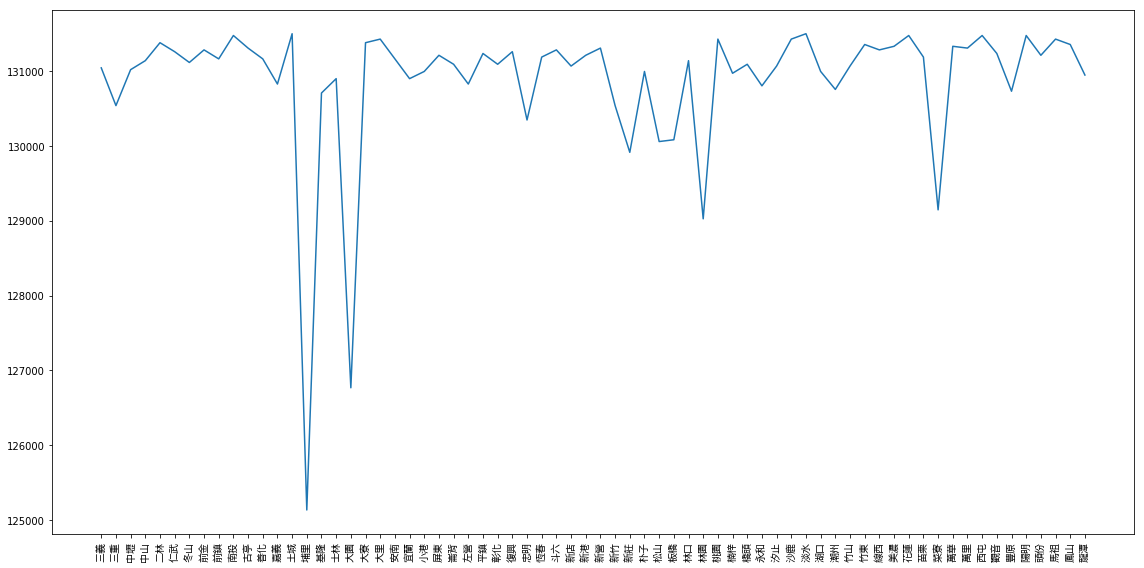

station
埔里    125136
大園    126768
新莊    129912
林園    129024
菜寮    129144
dtype: int64

In [23]:
stns = list(set(output['station']))
sfreq = output.groupby('station').size()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="NotoSansCJKtc-Regular.otf", size=10)

plt.figure(figsize=(16,8))
plt.plot(sfreq)
plt.xticks(np.arange(len(sfreq)), sfreq.index, fontproperties=font, rotation=90)
plt.tight_layout()
plt.show()

sfreq[sfreq<130000]